In [6]:
import clip
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json 
import sys 
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.insert(0, os.path.dirname(os.getcwd()))
import loaders
from utils import scores as sc
from utils import evaluation as ev

In [7]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [8]:
import logging
# Set Logger
logger = logging.getLogger('notebook_logger')
logger.setLevel(logging.DEBUG)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

# Define Data Loader

In [9]:
# Showing one example
# TODO: Add VSNR for cosine similarity
data_loader = loaders.DataLoader(data_source = "qa", logger=logger)
df_table = data_loader.load_dialogue_df()

#k = 5
#data_loader.showing_example(k)
#data_loader.show_clip_similarity(k, df_table, model, preprocess)

In [10]:
df_table

,image_id,dialog,caption,dialog_full,file_name,name,supercategory,set_source
0,378466,"[{'answer': 39276, 'gt_index': 74, 'question':...",a person that is laying next to a dog,Q: is this a child or adult\nA: adult\nQ: male...,COCO_train2014_000000378466.jpg,"[dog, person, bed]","[animal, person, furniture]",train2014
1,575029,"[{'answer': 216336, 'gt_index': 93, 'question'...",a black and white photo of a man on a horse by...,"Q: what color is horse\nA: brown, but it's bla...",COCO_train2014_000000575029.jpg,"[horse, car, person, tie, banana]","[animal, vehicle, person, accessory, food]",train2014
2,287140,"[{'answer': 64297, 'gt_index': 21, 'question':...",a couple of people and some motor bikes,Q: how many bikes there\nA: 3\nQ: what color a...,COCO_train2014_000000287140.jpg,"[motorcycle, person]","[vehicle, person]",train2014
3,378461,"[{'answer': 249727, 'gt_index': 20, 'question'...","a kitchen with light colored wood cabinets, a ...",Q: what color is the sink\nA: white\nQ: is the...,COCO_train2014_000000378461.jpg,"[person, oven, sink]","[person, appliance]",train2014
4,332243,"[{'answer': 71412, 'gt_index': 30, 'question':...",a giraffe takes food from a feeding bin high u...,Q: is this a zoo\nA: yes\nQ: how many giraffes...,COCO_train2014_000000332243.jpg,"[cow, zebra, giraffe]",[animal],train2014
...,...,...,...,...,...,...,...,...
122213,229324,"[{'answer': 59111, 'gt_index': 40, 'question':...",an empty kitchen with a center island made out...,Q: is this a large kitchen\nA: yes\nQ: can you...,COCO_val2014_000000229324.jpg,"[microwave, sink]",[appliance],val2014
122214,213795,"[{'answer': 59111, 'gt_index': 51, 'question':...",2 elephants pf different heights walking while...,Q: is this photo in color\nA: yes\nQ: any peop...,COCO_val2014_000000213795.jpg,[elephant],[animal],val2014
122215,464476,"[{'answer': 88516, 'gt_index': 21, 'question':...",a man is seen walking out of a building,Q: how old is the man\nA: i can only see his b...,COCO_val2014_000000464476.jpg,"[tv, train, person]","[electronic, vehicle, person]",val2014
122216,234766,"[{'answer': 59111, 'gt_index': 50, 'question':...",a skateboarder is in the air as he performs a ...,Q: is the image in color\nA: yes\nQ: is it day...,COCO_val2014_000000234766.jpg,"[person, skateboard]","[person, sports]",val2014


# Define OOD Categories below

In [11]:
ood_category = ['vehicle']
ind_category = [x for x in data_loader.supercategories if x not in ood_category]
df_table['OOD'] = df_table['supercategory'].apply(lambda x: 1 if any(item in x for item in ind_category) else 0)
df_table['OOD'].value_counts()

OOD
1    116167
0      6051
Name: count, dtype: int64

# Load CLIP features for images and dialogues with Model CLIP ViT-B32

In [12]:
if data_loader.data_source == "real":
    ## Dialogue Processing
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_truncate/mmd_clip_dialog_features.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)

    ## Image Processing
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_imgs_filenames.json')
    image_annotation = image_annotation.rename(columns={0:"img_file"}).join(pd.DataFrame(pd.DataFrame(image_clip.tolist()).apply(np.array, axis=1)))
    image_annotation.rename(columns={0:"image_clip"}, inplace=True)
    df_table = df_table.merge(image_annotation, on='img_file', how='left')

elif data_loader.data_source == "qa":
    ## Dialogue Processing
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/qa_dialogs_truncate/qa_clip_dialog_features.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)

    ## Image Processing
    df_table['image_file'] = df_table['image_id'].astype('str') + '.jpg'
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/qa_imgs/qa_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/qa_imgs/all_img_names.json')
    image_annotation = image_annotation.rename(columns={0:"image_file"})
    image_annotation['image_clip'] = list(image_clip)
    df_table = df_table.merge(image_annotation, on='image_file', how='left') 

    

In [13]:
#dialogue_df_segment = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_dialogs_segment/new_mmd_expand_dialog.json')
#dialogue_clip_segment = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_segment/new_mmd_dialog_features.npy')
#dialogue_df_segment['dialogue_clip'] = list(dialogue_clip_segment)

In [14]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=ind_category)
df_table['encoded_label'] = list(mlb.fit_transform(df_table['supercategory']))
encoded_df = pd.DataFrame(df_table['encoded_label'].tolist(), columns=ind_category)
df_table = pd.concat([df_table, encoded_df], axis=1)

In [15]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
tqdm.pandas()

#if data_loader.data_source == "qa":
#    df_table['image_id'] = df_table['image_id'].apply(lambda x: f"COCO_train2014_{int(x):012d}")

categories_clip = {}
for categories in ind_category:
    text = 'Category ' + categories
    text_tokens = clip.tokenize([text]).to(device)  
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).flatten().cpu().numpy()
        categories_clip[categories] = text_features

def calculate_similarity_score(row, type = "image"):
    if type == "image":
        column = 'image_clip'
    elif type == "dialogue":
        column = 'dialogue_clip'

    cosine_sim = 0
    cosine_sim_max = 0
    for categories in ind_category:
        text_features = categories_clip[categories]
        cosine_sim_current = np.dot(text_features, row[column]) / (np.linalg.norm(text_features) * np.linalg.norm(row[column]))
        cosine_sim += cosine_sim_current
        cosine_sim_max = max(cosine_sim_max, cosine_sim_current)


    return cosine_sim, cosine_sim_max

df_table['image_score'], df_table['image_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1))
#dialogue_df_segment['dialogue_score'], dialogue_df_segment['dialogue_score_max'] = zip(*dialogue_df_segment.progress_apply(calculate_similarity_score, type = "dialogue", axis=1))
df_table['dialogue_score'], df_table['dialogue_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1, args=('dialogue',)))

  0%|          | 0/122218 [00:00<?, ?it/s]

  0%|          | 0/122218 [00:00<?, ?it/s]

In [16]:
#df_table['dialogue_score_segment'] = pd.DataFrame(dialogue_df_segment.groupby('index')['dialogue_score'].mean())['dialogue_score'].values
#df_table['dialogue_score_segment_max'] = pd.DataFrame(dialogue_df_segment.groupby('index')['dialogue_score_max'].mean())['dialogue_score_max'].values

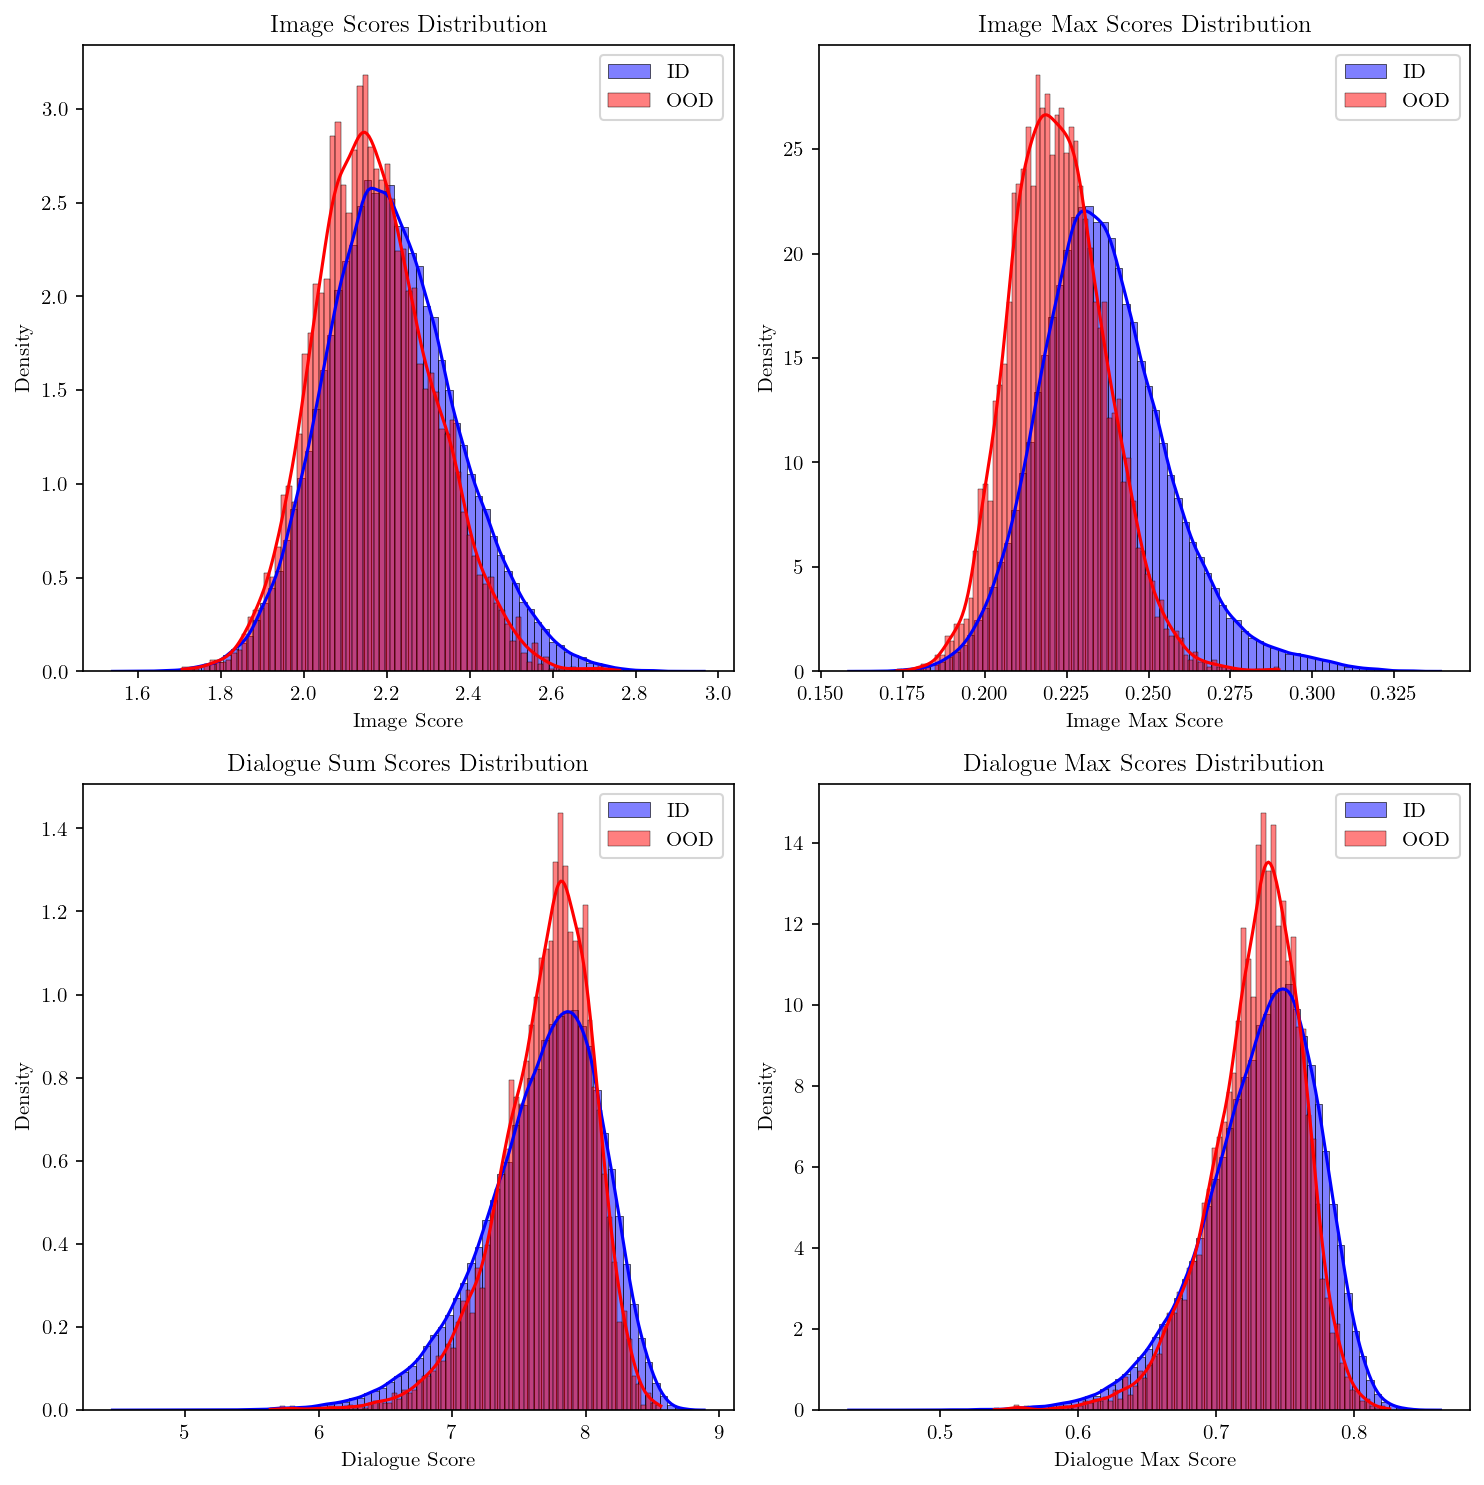

In [18]:
import importlib
importlib.reload(ev)

<module 'utils.evaluation' from 'f:\\Github\\multimodal_ood\\utils\\evaluation.py'>

In [19]:
def image_text_similarity(row):
    a = row['dialogue_clip']
    b = row['image_clip']
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim
df_table['image_text_similarity'] = df_table.apply(image_text_similarity, axis=1)
df_table['overall_simialrity'] = df_table['image_text_similarity'] * (df_table['image_score_max'] + 0.01*df_table['dialogue_score_max'])
df_table['overall_simialrity_sum'] = df_table['image_text_similarity'] * (df_table['image_score'] + 0.01*df_table['dialogue_score'])

In [20]:
print('Image Max:', ev.fpr_evaluation(df_table['OOD'].values, df_table['image_score_max'].values, 0.95))
print('Image Sum:', ev.fpr_evaluation(df_table['OOD'].values, df_table['image_score'].values, 0.95))
print('Dialogue Max:', ev.fpr_evaluation(df_table['OOD'].values, df_table['dialogue_score_max'].values, 0.95))
print('Dialogue Sum:', ev.fpr_evaluation(df_table['OOD'].values, df_table['dialogue_score'].values, 0.95))
#print('Dialogue Segment Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment_max'].values, 0.95))
#print('Dialogue Segment Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment'].values, 0.95))
print("Overall Max:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity'].values, 0.95))
print("Overall Sum:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity_sum'].values, 0.95))

Image Max: 0.8730788299454636
Image Sum: 0.9403404395967608
Dialogue Max: 0.9714096843496942
Dialogue Sum: 0.9781854238968766
Overall Max: 0.9629813254007602
Overall Sum: 0.9722359940505702


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from models.DNN import model 

image_model_loader = model.model_loader(logger=logger,
                                  num_epochs=6,
                                  learning_rate=0.001,
                                  proportion = 0.8,
                                  seed = 20)


2024-05-16 20:17:41,473 - notebook_logger - INFO - Setting random seed: 20
2024-05-16 20:17:41,473 - notebook_logger - INFO - Setting random seed: 20


In [22]:
dialogue_model_loader = model.model_loader(logger=logger,
                                    num_epochs=6,
                                    learning_rate=0.001,
                                    seed = 20)

2024-05-16 20:17:41,493 - notebook_logger - INFO - Setting random seed: 20
2024-05-16 20:17:41,493 - notebook_logger - INFO - Setting random seed: 20


In [23]:
(
    df_ind_train, 
    df_test, 
    X_train_image, 
    X_test_image, 
    X_train_dialogue, 
    X_test_dialogue, 
    Y_train, 
    Y_test) = image_model_loader.create_dataset(data_loader, df_table, add_mismatch = True, mismatch_num = 5000)

df_test['image_text_similarity'] = df_test.apply(image_text_similarity, axis=1)

In [24]:
image_model_loader.train_model(X_train_image, Y_train, X_test_image, Y_test)

  0%|          | 0/6 [00:00<?, ?it/s]2024-05-16 20:17:57,106 - notebook_logger - INFO - Epoch 1, Train Loss: 0.1561, Train Accuracy: 0.5535, Test Loss: 0.1718, Test Accuracy: 0.4703
2024-05-16 20:17:57,106 - notebook_logger - INFO - Epoch 1, Train Loss: 0.1561, Train Accuracy: 0.5535, Test Loss: 0.1718, Test Accuracy: 0.4703
 17%|█▋        | 1/6 [00:14<01:12, 14.55s/it]2024-05-16 20:18:11,327 - notebook_logger - INFO - Epoch 2, Train Loss: 0.1439, Train Accuracy: 0.5730, Test Loss: 0.1712, Test Accuracy: 0.4624
2024-05-16 20:18:11,327 - notebook_logger - INFO - Epoch 2, Train Loss: 0.1439, Train Accuracy: 0.5730, Test Loss: 0.1712, Test Accuracy: 0.4624
 33%|███▎      | 2/6 [00:28<00:57, 14.36s/it]2024-05-16 20:18:25,578 - notebook_logger - INFO - Epoch 3, Train Loss: 0.1358, Train Accuracy: 0.5935, Test Loss: 0.1695, Test Accuracy: 0.4693
2024-05-16 20:18:25,578 - notebook_logger - INFO - Epoch 3, Train Loss: 0.1358, Train Accuracy: 0.5935, Test Loss: 0.1695, Test Accuracy: 0.4693
 50

In [25]:
dialogue_model_loader.train_model(X_train_dialogue, Y_train, X_test_dialogue, Y_test)

  0%|          | 0/6 [00:00<?, ?it/s]2024-05-16 20:19:22,563 - notebook_logger - INFO - Epoch 1, Train Loss: 0.2446, Train Accuracy: 0.3898, Test Loss: 0.3251, Test Accuracy: 0.2756
2024-05-16 20:19:22,563 - notebook_logger - INFO - Epoch 1, Train Loss: 0.2446, Train Accuracy: 0.3898, Test Loss: 0.3251, Test Accuracy: 0.2756
 17%|█▋        | 1/6 [00:14<01:12, 14.42s/it]2024-05-16 20:19:37,575 - notebook_logger - INFO - Epoch 2, Train Loss: 0.2294, Train Accuracy: 0.4208, Test Loss: 0.3355, Test Accuracy: 0.2930
2024-05-16 20:19:37,575 - notebook_logger - INFO - Epoch 2, Train Loss: 0.2294, Train Accuracy: 0.4208, Test Loss: 0.3355, Test Accuracy: 0.2930
 33%|███▎      | 2/6 [00:29<00:59, 14.77s/it]2024-05-16 20:19:52,170 - notebook_logger - INFO - Epoch 3, Train Loss: 0.2231, Train Accuracy: 0.4339, Test Loss: 0.3261, Test Accuracy: 0.3107
2024-05-16 20:19:52,170 - notebook_logger - INFO - Epoch 3, Train Loss: 0.2231, Train Accuracy: 0.4339, Test Loss: 0.3261, Test Accuracy: 0.3107
 50

In [26]:
score_type_list = ["mp", "energy", "logits", "msp"]

for score_type in score_type_list:
    image_score_sum, image_score_max = image_model_loader.evaluate_on_test(X_test_image, 
                                                        Y_test,
                                                        score_type=score_type,\
                                                        return_score=True)
    
    dialogue_score_sum, dialogue_score_max = dialogue_model_loader.evaluate_on_test(X_test_dialogue, 
                                                        Y_test,
                                                        score_type=score_type,\
                                                        return_score=True)
    
    df_test[f'{score_type}_sum_image'] = image_score_sum
    df_test[f'{score_type}_max_image'] = image_score_max
    df_test[f'{score_type}_sum_dialogue'] = dialogue_score_sum
    df_test[f'{score_type}_max_dialogue'] = dialogue_score_max
    df_test[f'{score_type}_max_image_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_max_image'] 
    df_test[f'{score_type}_max_dialogue_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_max_dialogue']
    df_test[f'{score_type}_sum_image_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_sum_image']
    df_test[f'{score_type}_sum_dialogue_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_sum_dialogue']

    df_test[f'{score_type}_overall_simialrity_max'] =  df_test[f'{score_type}_max_image_tranform'] + df_test[f'{score_type}_max_dialogue_tranform']
    if score_type in ["energy", "logits"]:
        df_test[f'{score_type}_overall_simialrity_sum'] = df_test[f'{score_type}_sum_image_tranform'] + df_test[f'{score_type}_sum_dialogue_tranform']

2024-05-16 20:20:36,449 - notebook_logger - INFO - Test Loss: 0.1600, Test Accuracy: 0.4937
2024-05-16 20:20:36,449 - notebook_logger - INFO - Test Loss: 0.1600, Test Accuracy: 0.4937
2024-05-16 20:20:37,355 - notebook_logger - INFO - Test Loss: 0.3252, Test Accuracy: 0.3159
2024-05-16 20:20:37,355 - notebook_logger - INFO - Test Loss: 0.3252, Test Accuracy: 0.3159
2024-05-16 20:20:38,305 - notebook_logger - INFO - Test Loss: 0.1600, Test Accuracy: 0.4937
2024-05-16 20:20:38,305 - notebook_logger - INFO - Test Loss: 0.1600, Test Accuracy: 0.4937
2024-05-16 20:20:39,220 - notebook_logger - INFO - Test Loss: 0.3252, Test Accuracy: 0.3159
2024-05-16 20:20:39,220 - notebook_logger - INFO - Test Loss: 0.3252, Test Accuracy: 0.3159
2024-05-16 20:20:40,108 - notebook_logger - INFO - Test Loss: 0.1600, Test Accuracy: 0.4937
2024-05-16 20:20:40,108 - notebook_logger - INFO - Test Loss: 0.1600, Test Accuracy: 0.4937
2024-05-16 20:20:41,013 - notebook_logger - INFO - Test Loss: 0.3252, Test Accur

In [27]:
score_type = "energy"
type = "sum"
mode = "image"
fpr = 95

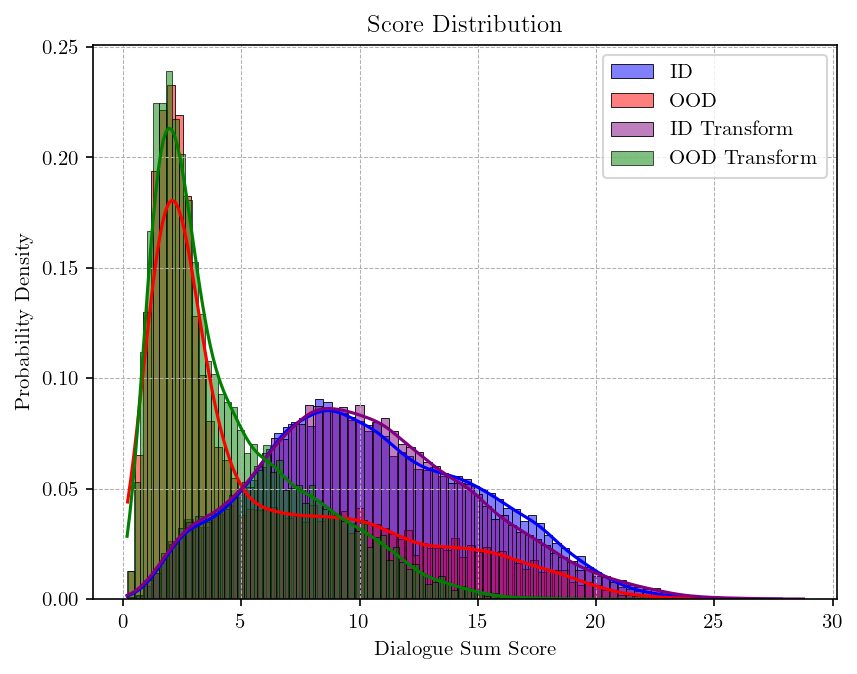

In [28]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_{type}_{mode}']
non_ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_{type}_{mode}']

ood_scores_transform = df_test[df_test['OOD'] == 0][f'{score_type}_{type}_{mode}_tranform']
non_ood_scores_transform = df_test[df_test['OOD'] == 1][f'{score_type}_{type}_{mode}_tranform']

sns.histplot(non_ood_scores, bins=80, alpha=0.5, label='ID', kde=True, color='blue',stat="density")
sns.histplot(ood_scores, bins=80, alpha=0.5, label='OOD', kde=True, color='red', stat="density")

sns.histplot(non_ood_scores_transform, bins=80, alpha=0.5, label='ID Transform', kde=True, color='purple',stat="density")
sns.histplot(ood_scores_transform, bins=80, alpha=0.5, label='OOD Transform', kde=True, color='green', stat="density")

plt.title(f'Score Distribution')
plt.xlabel(f'Dialogue {type.title()} Score')
plt.ylabel('Probability Density')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()



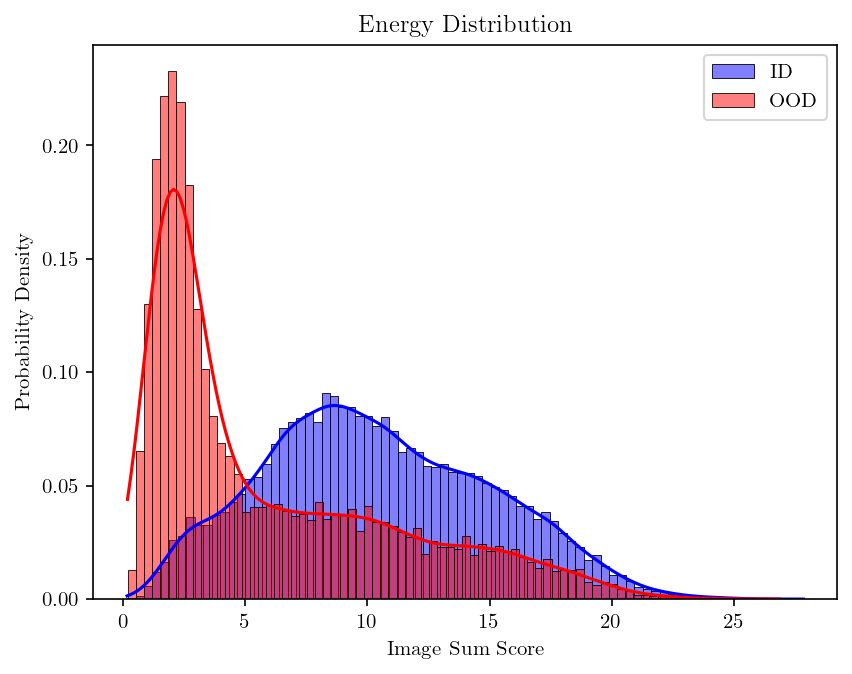

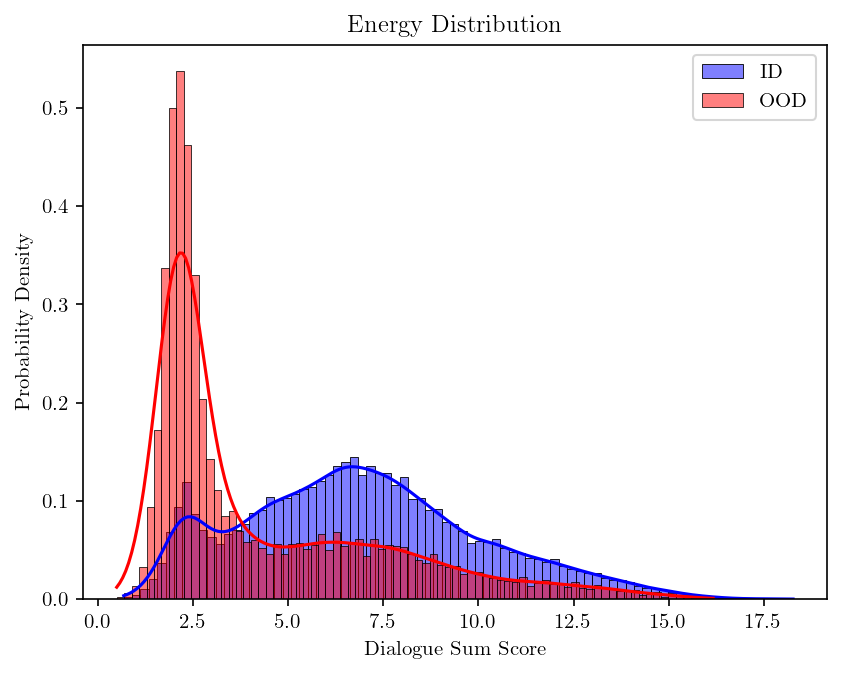

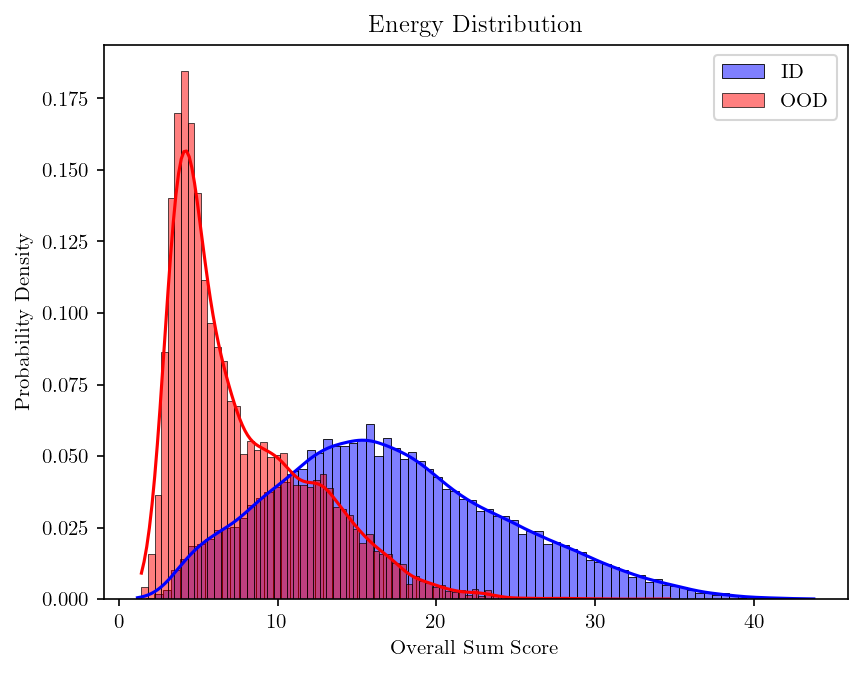

In [33]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_{type}_image']
non_ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_{type}_image']

ood_scores_transform = df_test[df_test['OOD'] == 0][f'{score_type}_{type}_image_tranform']
non_ood_scores_transform = df_test[df_test['OOD'] == 1][f'{score_type}_{type}_image_tranform']

sns.histplot(non_ood_scores, bins=80, alpha=0.5, label='ID', kde=True, color='blue',stat="density")
sns.histplot(ood_scores, bins=80, alpha=0.5, label='OOD', kde=True, color='red', stat="density")
#sns.histplot(non_ood_scores_transform, bins=80, alpha=0.5, label='ID', kde=True, color='green',stat="density")
#sns.histplot(ood_scores_transform, bins=80, alpha=0.5, label='OOD', kde=True, color='purple', stat="density")

plt.title(f'{score_type.title()} Distribution')
plt.xlabel(f'Image {type.title()} Score')
plt.ylabel('Probability Density')
plt.legend()
plt.savefig(f'{data_loader.data_dir}/CLIP/qa_imgs/{score_type}_{type}_image.pdf')
plt.show()

ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_{type}_dialogue']
non_ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_{type}_dialogue']

sns.histplot(non_ood_scores, bins=80, alpha=0.5, label='ID', kde=True, color='blue',stat="density")
sns.histplot(ood_scores, bins=80, alpha=0.5, label='OOD', kde=True, color='red', stat="density")
plt.title('Energy Distribution')
plt.xlabel(f'Dialogue {type.title()} Score')
plt.ylabel('Probability Density')
plt.legend()
plt.savefig(f'{data_loader.data_dir}/CLIP/qa_imgs/{score_type}_{type}_dialogue.pdf')
plt.show()


ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_overall_simialrity_{type}']
non_ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_overall_simialrity_{type}']
sns.histplot(non_ood_scores, bins=80, alpha=0.5, label='ID', kde=True, color='blue',  stat="density")
sns.histplot(ood_scores, bins=80, alpha=0.5, label='OOD', kde=True, color='red',  stat="density")
plt.title('Energy Distribution')
plt.xlabel(f'Overall {type.title()} Score')
plt.ylabel('Probability Density')
plt.legend()
plt.savefig(f'{data_loader.data_dir}/CLIP/qa_imgs/{score_type}_overall_simialrity_{type}.pdf')
plt.show()

<>:25: SyntaxWarning: invalid escape sequence '\%'
<>:47: SyntaxWarning: invalid escape sequence '\%'
<>:67: SyntaxWarning: invalid escape sequence '\%'
<>:25: SyntaxWarning: invalid escape sequence '\%'
<>:47: SyntaxWarning: invalid escape sequence '\%'
<>:67: SyntaxWarning: invalid escape sequence '\%'
C:\Users\WFYIT\AppData\Local\Temp\ipykernel_11852\3110178882.py:25: SyntaxWarning: invalid escape sequence '\%'
  plt.axvline(x=threshold_value_id, color='green', linestyle='--', label=f'{fpr}\% Recall at {threshold_value_id:.2f}')
C:\Users\WFYIT\AppData\Local\Temp\ipykernel_11852\3110178882.py:47: SyntaxWarning: invalid escape sequence '\%'
  plt.axvline(x=threshold_value_id, color='green', linestyle='--', label=f'{fpr}\% Recall at {threshold_value_id:.2f}')
C:\Users\WFYIT\AppData\Local\Temp\ipykernel_11852\3110178882.py:67: SyntaxWarning: invalid escape sequence '\%'
  plt.axvline(x=threshold_value_id, color='green', linestyle='--', label=f'{fpr}\% Recall at {threshold_value_id:.2f}'

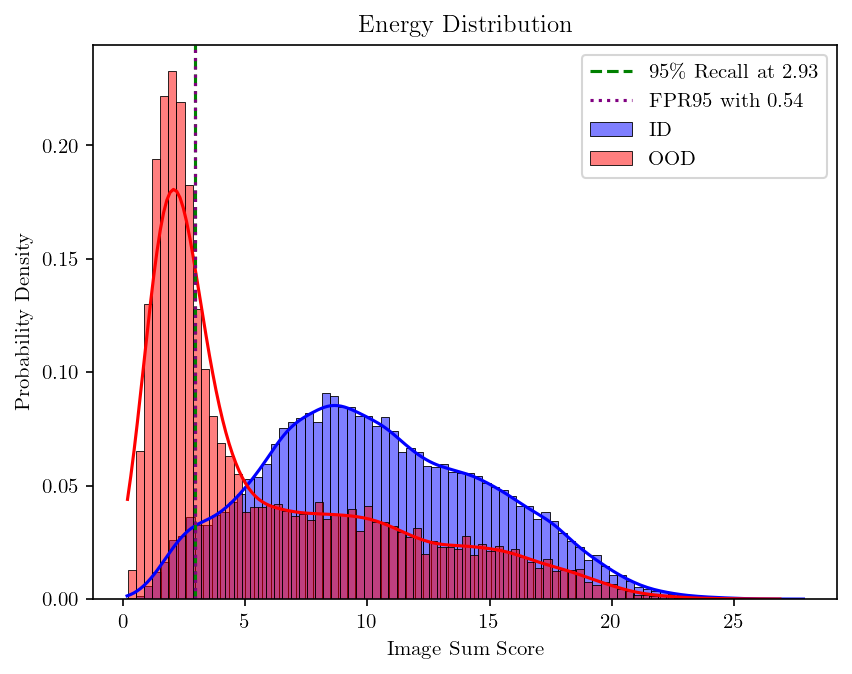

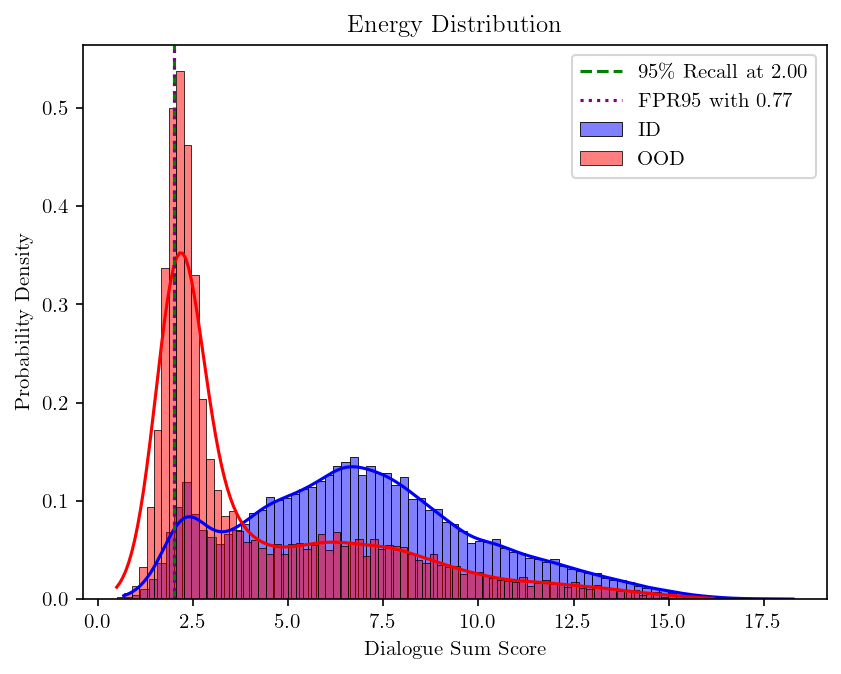

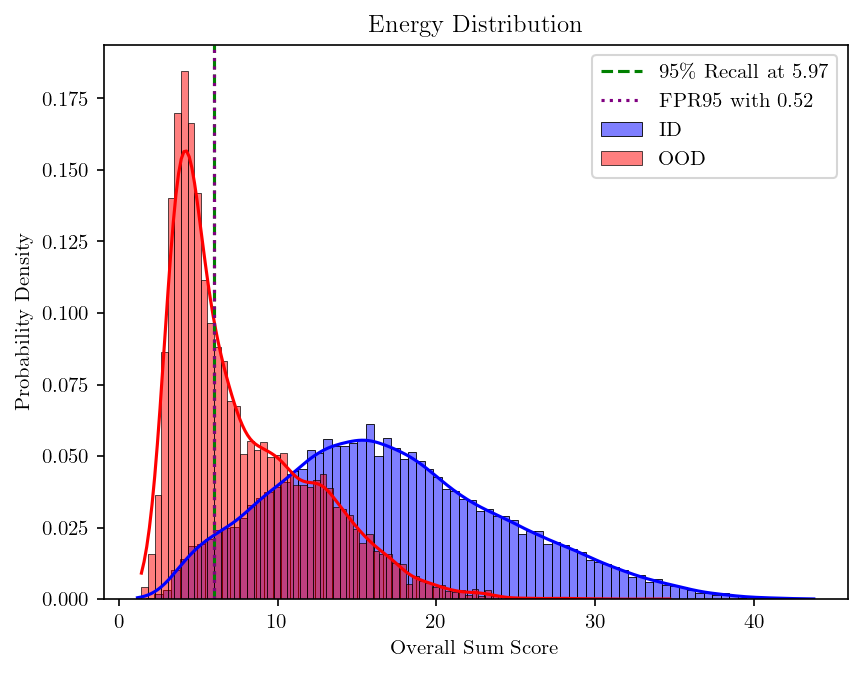

In [29]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_{type}_image']
non_ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_{type}_image']

ood_scores_transform = df_test[df_test['OOD'] == 0][f'{score_type}_{type}_image_tranform']
non_ood_scores_transform = df_test[df_test['OOD'] == 1][f'{score_type}_{type}_image_tranform']

sns.histplot(non_ood_scores, bins=80, alpha=0.5, label='ID', kde=True, color='blue',stat="density")
sns.histplot(ood_scores, bins=80, alpha=0.5, label='OOD', kde=True, color='red', stat="density")
#sns.histplot(non_ood_scores_transform, bins=80, alpha=0.5, label='ID', kde=True, color='green',stat="density")
#sns.histplot(ood_scores_transform, bins=80, alpha=0.5, label='OOD', kde=True, color='purple', stat="density")

plt.title(f'{score_type.title()} Distribution')
plt.xlabel(f'Image {type.title()} Score')
plt.ylabel('Probability Density')
hist_id, bins_id = np.histogram(non_ood_scores, bins=80, density=True)
cumulative_id = np.cumsum(hist_id * np.diff(bins_id))
threshold_index_id = np.where(cumulative_id >= (1 - fpr/100))[0][0]
threshold_value_id = bins_id[threshold_index_id]
hist_ood, bins_ood = np.histogram(ood_scores, bins=80, density=True)
cumulative_ood = np.cumsum(hist_ood * np.diff(bins_ood))
threshold_index_ood = np.searchsorted(bins_ood, threshold_value_id) - 1
cumulative_probability_ood = cumulative_ood[threshold_index_ood]
plt.axvline(x=threshold_value_id, color='green', linestyle='--', label=f'{fpr}\% Recall at {threshold_value_id:.2f}')
plt.axvline(x=threshold_value_id, color='purple', linestyle=':', label=f'FPR{fpr} with {(1 - cumulative_probability_ood):.2f}')
plt.legend()
plt.savefig(f'{data_loader.data_dir}/CLIP/qa_imgs/{score_type}_{type}_image.pdf')
plt.show()

ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_{type}_dialogue']
non_ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_{type}_dialogue']

sns.histplot(non_ood_scores, bins=80, alpha=0.5, label='ID', kde=True, color='blue',stat="density")
sns.histplot(ood_scores, bins=80, alpha=0.5, label='OOD', kde=True, color='red', stat="density")
plt.title('Energy Distribution')
plt.xlabel(f'Dialogue {type.title()} Score')
plt.ylabel('Probability Density')
hist_id, bins_id = np.histogram(non_ood_scores, bins=80, density=True)
cumulative_id = np.cumsum(hist_id * np.diff(bins_id))
threshold_index_id = np.where(cumulative_id >= (1 - fpr/100))[0][0]
threshold_value_id = bins_id[threshold_index_id]
hist_ood, bins_ood = np.histogram(ood_scores, bins=80, density=True)
cumulative_ood = np.cumsum(hist_ood * np.diff(bins_ood))
threshold_index_ood = np.searchsorted(bins_ood, threshold_value_id) - 1
cumulative_probability_ood = cumulative_ood[threshold_index_ood]
plt.axvline(x=threshold_value_id, color='green', linestyle='--', label=f'{fpr}\% Recall at {threshold_value_id:.2f}')
plt.axvline(x=threshold_value_id, color='purple', linestyle=':', label=f'FPR{fpr} with {(1 - cumulative_probability_ood):.2f}')
plt.legend()
plt.show()

ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_overall_simialrity_{type}']
non_ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_overall_simialrity_{type}']
sns.histplot(non_ood_scores, bins=80, alpha=0.5, label='ID', kde=True, color='blue',  stat="density")
sns.histplot(ood_scores, bins=80, alpha=0.5, label='OOD', kde=True, color='red',  stat="density")
plt.title('Energy Distribution')
plt.xlabel(f'Overall {type.title()} Score')
plt.ylabel('Probability Density')
hist_id, bins_id = np.histogram(non_ood_scores, bins=80, density=True)
cumulative_id = np.cumsum(hist_id * np.diff(bins_id))
threshold_index_id = np.where(cumulative_id >= (1 - fpr/100))[0][0]
threshold_value_id = bins_id[threshold_index_id]
hist_ood, bins_ood = np.histogram(ood_scores, bins=80, density=True)
cumulative_ood = np.cumsum(hist_ood * np.diff(bins_ood))
threshold_index_ood = np.searchsorted(bins_ood, threshold_value_id) - 1
cumulative_probability_ood = cumulative_ood[threshold_index_ood]
plt.axvline(x=threshold_value_id, color='green', linestyle='--', label=f'{fpr}\% Recall at {threshold_value_id:.2f}')
plt.axvline(x=threshold_value_id, color='purple', linestyle=':', label=f'FPR{fpr} with {(1 - cumulative_probability_ood):.2f}')
plt.legend()
plt.savefig(f'{data_loader.data_dir}/CLIP/qa_imgs/{score_type}_overall_simialrity_{type}.pdf')
plt.show()

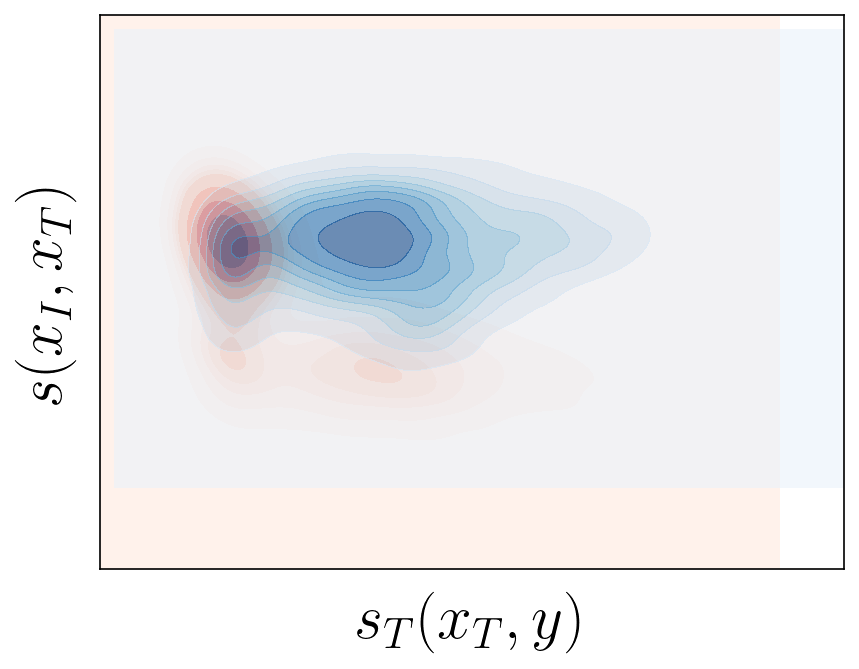

In [84]:
score_type = "energy"
type = "sum"
modality = "dialogue"

fig, ax = plt.subplots()
sns.kdeplot(
    x=df_test[df_test['OOD'] == 0][f'{score_type}_{type}_{modality}'],
    y=2*df_test[df_test['OOD'] == 0]['image_text_similarity'],
    cmap='Reds',
    fill=True,
    thresh=0,
    levels=10,
    alpha=1,
    ax=ax
)
sns.kdeplot(
    x=df_test[df_test['OOD'] == 1][f'{score_type}_{type}_{modality}'],
    y=2*df_test[df_test['OOD'] == 1]['image_text_similarity'],
    cmap='Blues',
    fill=True,
    thresh=0,
    levels=10,
    alpha=0.6,
    ax=ax
)
ax.set_xlabel(f'$s_T(x_T, y)$', fontsize = 30)
ax.set_ylabel(f'$s(x_I, x_T)$', fontsize = 30)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False)
plt.savefig(f'{data_loader.data_dir}/CLIP/qa_imgs/{score_type}_{type}_{modality}_kde.png', bbox_inches='tight')
plt.show()

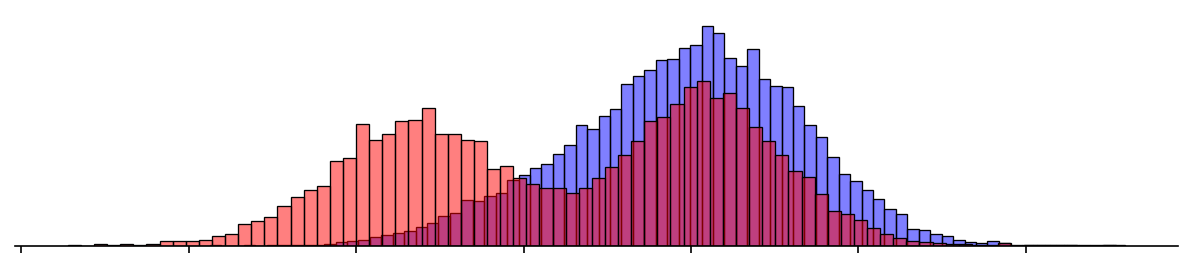

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 0][f'image_text_similarity']
non_ood_scores = df_test[df_test['OOD'] == 1][f'image_text_similarity']

fig, ax = plt.subplots(figsize=(10, 2))
sns.histplot(
    non_ood_scores, 
    bins=80, 
    alpha=0.5, 
    label='ID', 
    kde=False, 
    color='blue', 
    stat="density",
    ax=ax
)

sns.histplot(
    ood_scores, 
    bins=80, 
    alpha=0.5, 
    label='OOD', 
    kde=False, 
    color='red', 
    stat="density",
    ax=ax
)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.tick_params(axis='y', which='both', left=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('')

plt.savefig(f'{data_loader.data_dir}/CLIP/qa_imgs/{score_type}_{type}_similarity_hist.png', bbox_inches='tight')
plt.show()

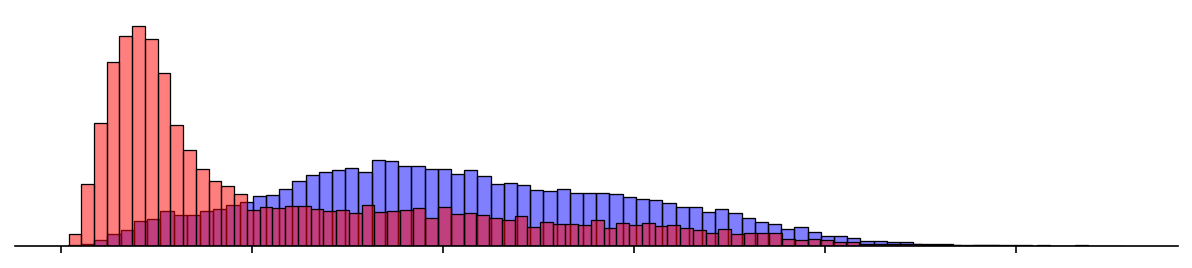

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_{type}_{modality}']
non_ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_{type}_{modality}']

fig, ax = plt.subplots(figsize=(10, 2))
sns.histplot(
    non_ood_scores, 
    bins=80, 
    alpha=0.5, 
    label='ID', 
    kde=False, 
    color='blue', 
    stat="density",
    ax=ax
)

sns.histplot(
    ood_scores, 
    bins=80, 
    alpha=0.5, 
    label='OOD', 
    kde=False, 
    color='red', 
    stat="density",
    ax=ax
)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.tick_params(axis='y', which='both', left=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig(f'{data_loader.data_dir}/CLIP/qa_imgs/{score_type}_{type}_{modality}_hist.png', bbox_inches='tight')
plt.show()

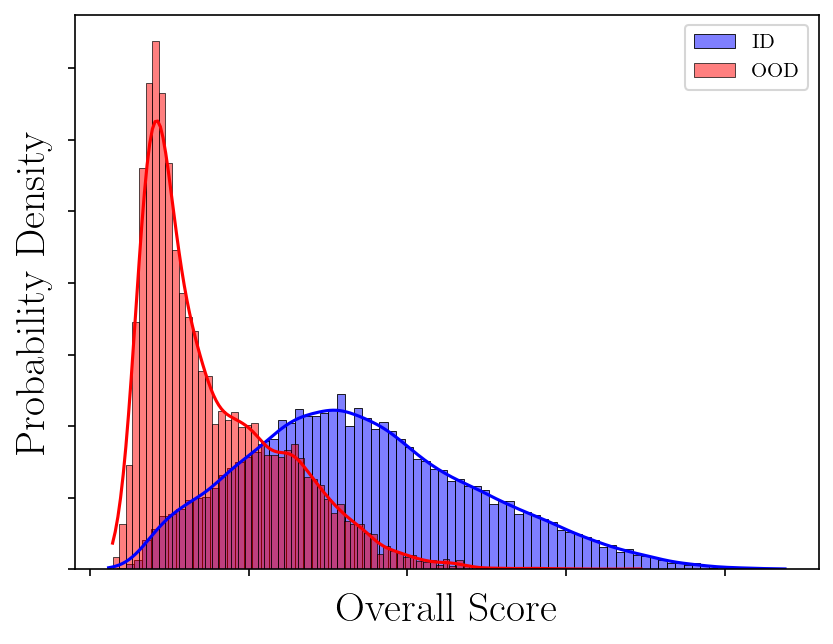

In [90]:

fig, ax = plt.subplots()

ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_overall_simialrity_{type}']
non_ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_overall_simialrity_{type}']
sns.histplot(non_ood_scores, bins=80, alpha=0.5, label='ID', kde=True, color='blue',  stat="density")
sns.histplot(ood_scores, bins=80, alpha=0.5, label='OOD', kde=True, color='red',  stat="density")
#plt.title('Score Distribution', fontsize = 30)
plt.xlabel(f'Overall Score', fontsize = 20)
plt.ylabel('Probability Density', fontsize = 20)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.legend()
plt.savefig(f'{data_loader.data_dir}/CLIP/qa_imgs/{score_type}_overall_simialrity_{type}.png', bbox_inches='tight')
plt.show()

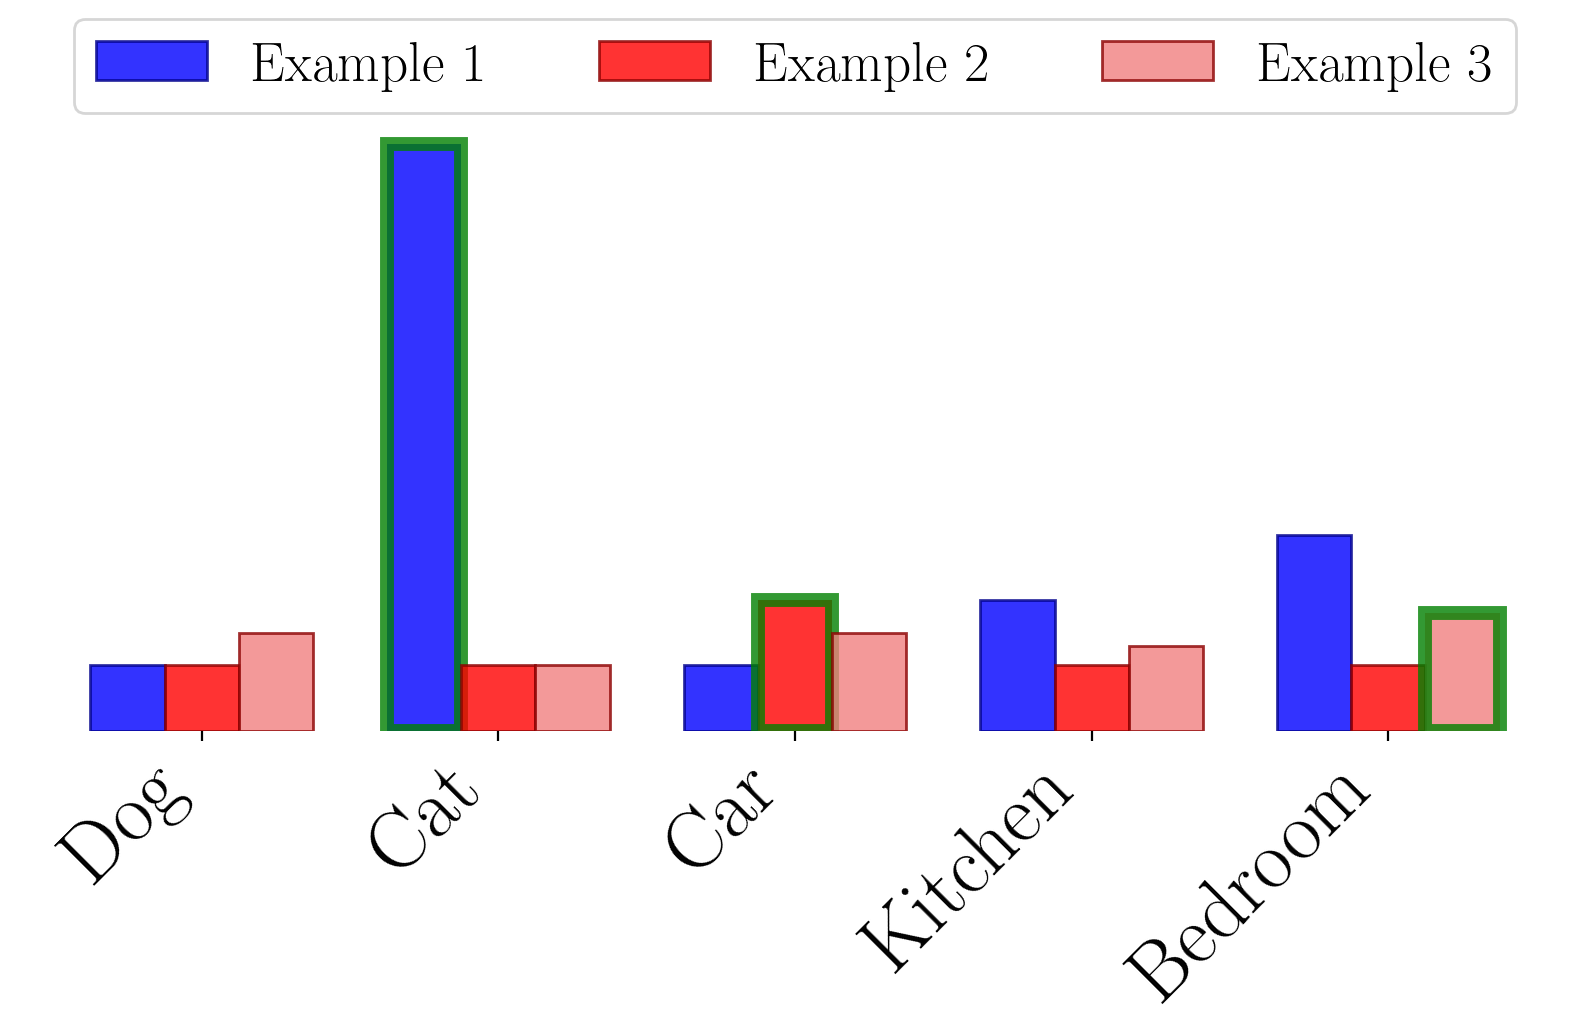

In [117]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['Dog', 'Cat', 'Car', 'Kitchen', 'Bedroom']
ind_bars = [0.1, 0.9, 0.1, 0.2, 0.3]
ood_bars_1 = [0.1, 0.1, 0.2, 0.1, 0.1]
ood_bars_2 = [0.15, 0.10, 0.15, 0.13, 0.18]

x = np.arange(len(categories))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 4), dpi=200)


rects1 = ax.bar(x - width, ind_bars, width, label='Example 1', color='blue', alpha=0.8, edgecolor='darkblue')
rects2 = ax.bar(x, ood_bars_1, width, label='Example 2', color='red', alpha=0.8, edgecolor='darkred')
rects3 = ax.bar(x + width, ood_bars_2, width, label='Example 3', color='lightcoral', alpha=0.8, edgecolor='darkred')

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=30)
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

max_ind_index = ind_bars.index(max(ind_bars))
max_ood_1_index = ood_bars_1.index(max(ood_bars_1))
max_ood_2_index = ood_bars_2.index(max(ood_bars_2))

rects1[max_ind_index].set_edgecolor('green')
rects1[max_ind_index].set_linewidth(5)

rects2[max_ood_1_index].set_edgecolor('green')
rects2[max_ood_1_index].set_linewidth(5)

rects3[max_ood_2_index].set_edgecolor('green')
rects3[max_ood_2_index].set_linewidth(5)

ax.legend(fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
plt.show()

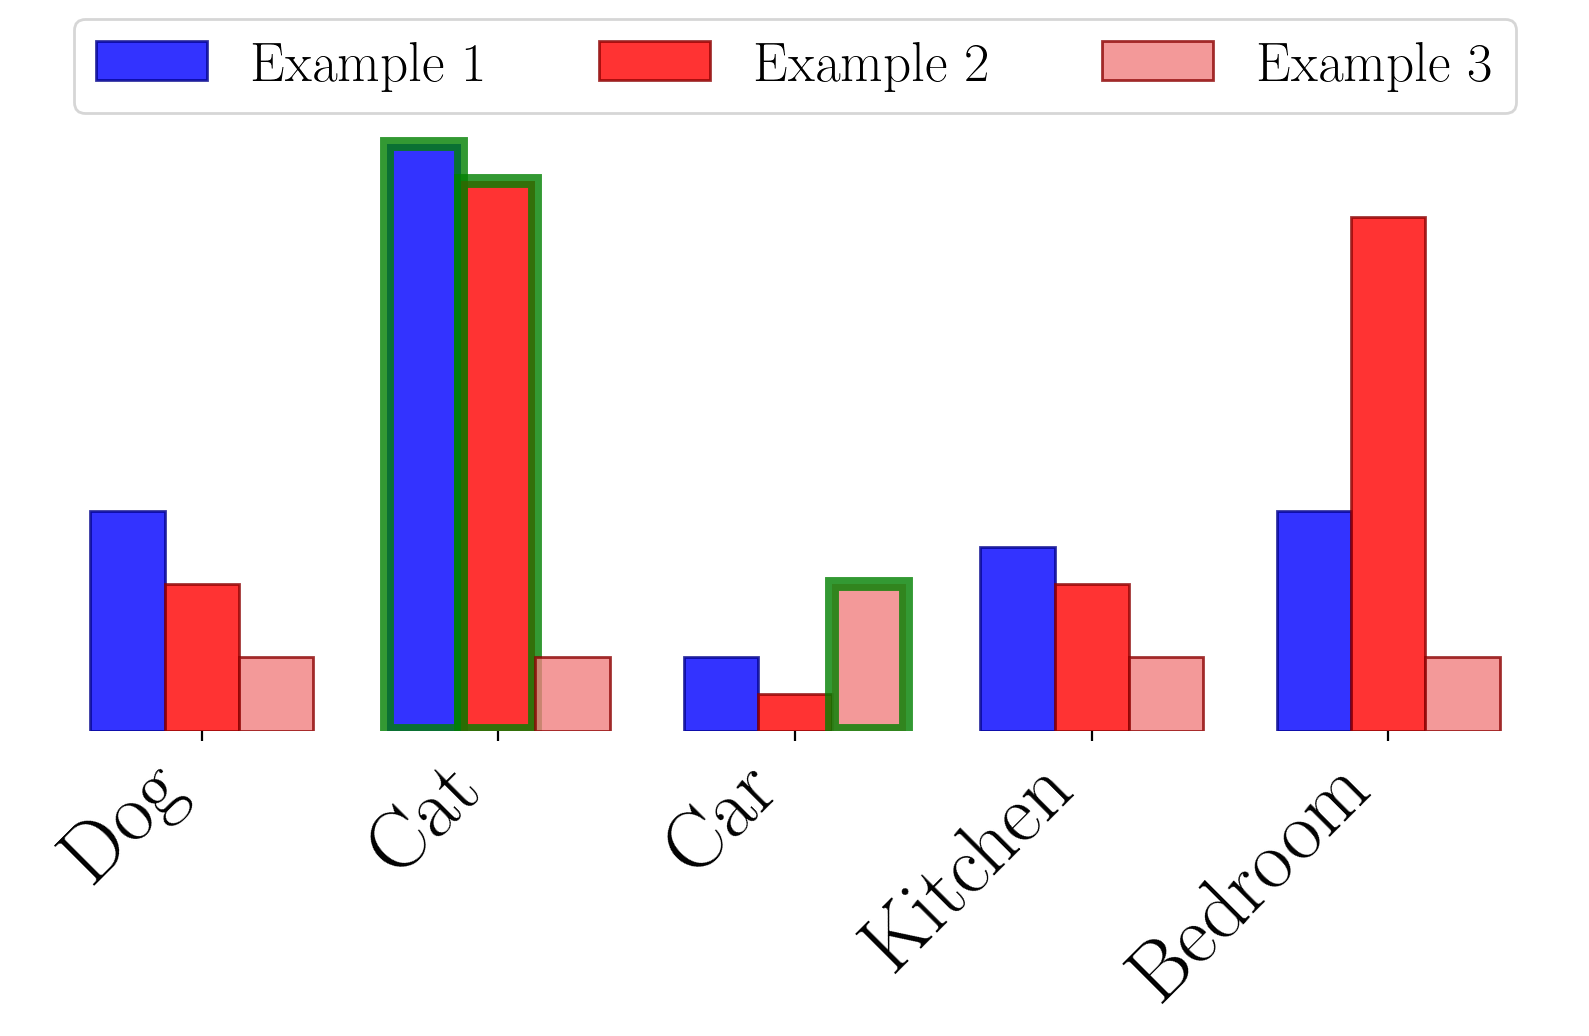

In [115]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
categories = ['Dog', 'Cat', 'Car', 'Kitchen', 'Bedroom']
ind_bars = [0.3, 0.8, 0.1, 0.25, 0.3]
ood_bars_1 = [0.2, 0.75, 0.05, 0.2, 0.7]
ood_bars_2 = [0.1, 0.1, 0.2, 0.1, 0.1]

x = np.arange(len(categories))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 4), dpi=200)


rects1 = ax.bar(x - width, ind_bars, width, label='Example 1', color='blue', alpha=0.8, edgecolor='darkblue')
rects2 = ax.bar(x, ood_bars_1, width, label='Example 2', color='red', alpha=0.8, edgecolor='darkred')
rects3 = ax.bar(x + width, ood_bars_2, width, label='Example 3', color='lightcoral', alpha=0.8, edgecolor='darkred')

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=30)
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# 标注最大值的条形
max_ind_index = ind_bars.index(max(ind_bars))
max_ood_1_index = ood_bars_1.index(max(ood_bars_1))
max_ood_2_index = ood_bars_2.index(max(ood_bars_2))

rects1[max_ind_index].set_edgecolor('green')
rects1[max_ind_index].set_linewidth(5)

rects2[max_ood_1_index].set_edgecolor('green')
rects2[max_ood_1_index].set_linewidth(5)

rects3[max_ood_2_index].set_edgecolor('green')
rects3[max_ood_2_index].set_linewidth(5)

ax.legend(fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
# 显示图表
plt.show()

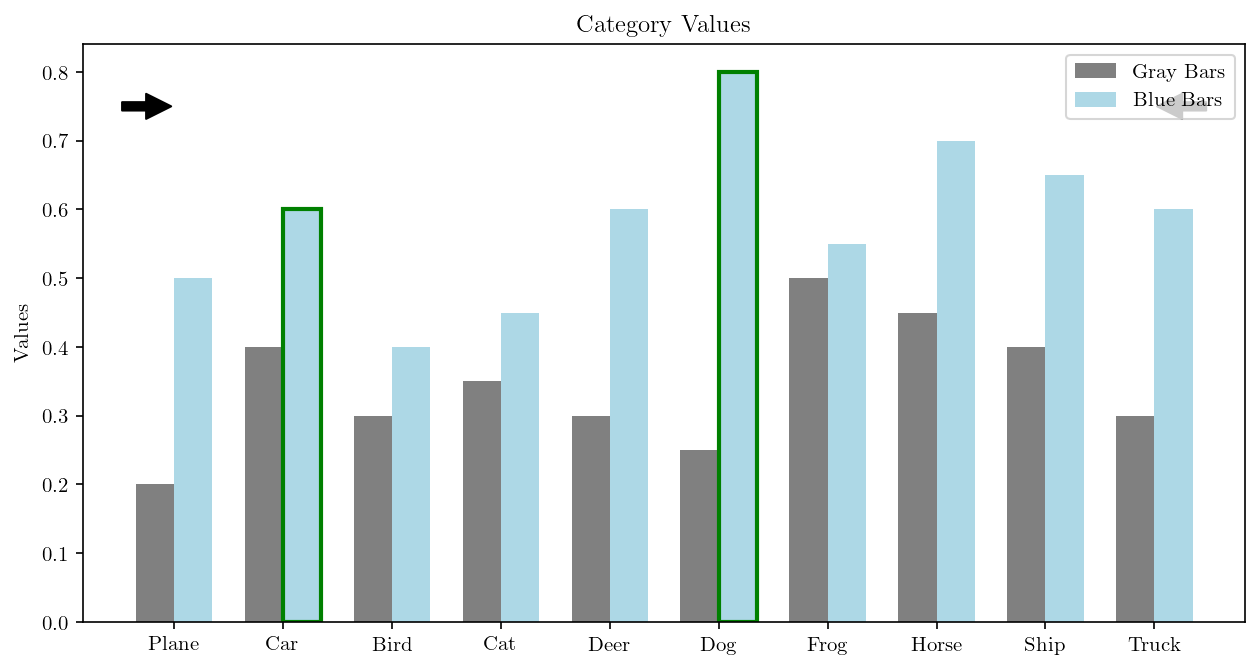

In [91]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['Dog', 'Cat', 'Car', 'Kitchen', 'Bedroom']
ind_bars = [0.3, 0.8, 0.1, 0.25, 0.3, 0.5]
ood_bars_1 = [0.2, 0.75, 0.05, 0.2, 0.7]
ood_bars_2 = [0.1, 0.1, 0.2, 0.1, 0.1]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, ind_bars, width, label='ID', color='blue')
rects2 = ax.bar(x + width/2, ood_bars_1, width, label='OOD', color='red')
rects3 = ax.bar(x + width/2, ood_bars_2, width, color='lightred')


highlighted_categories = ['Cat', 'Cat', 'Car']
highlighted_colors = ['green', 'green', 'green']
highlighted_indices = [categories.index(cat) for cat in highlighted_categories]

for idx, rect in enumerate(rects2):
    if idx in highlighted_indices:
        rect.set_edgecolor(highlighted_colors[highlighted_indices.index(idx)])
        rect.set_linewidth(2)

ax.set_ylabel('Values')
ax.set_title('Category Values')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

ax.annotate('', xy=(0, 0.75), xytext=(-0.5, 0.75),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('', xy=(9, 0.75), xytext=(9.5, 0.75),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

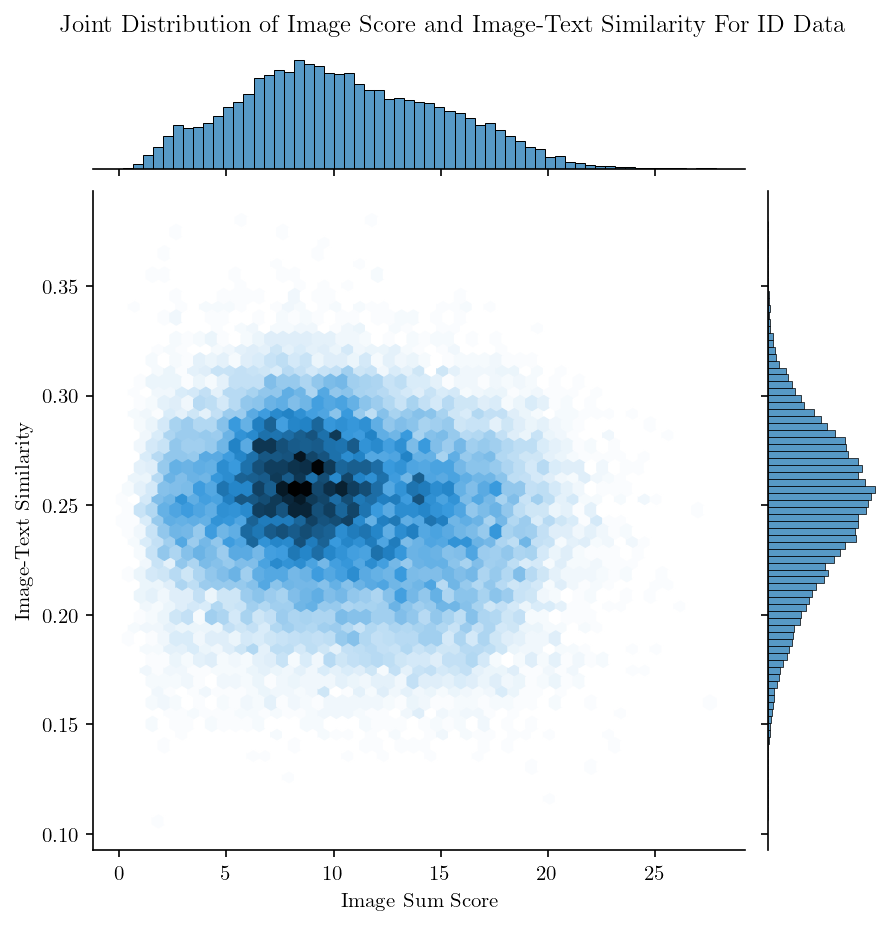

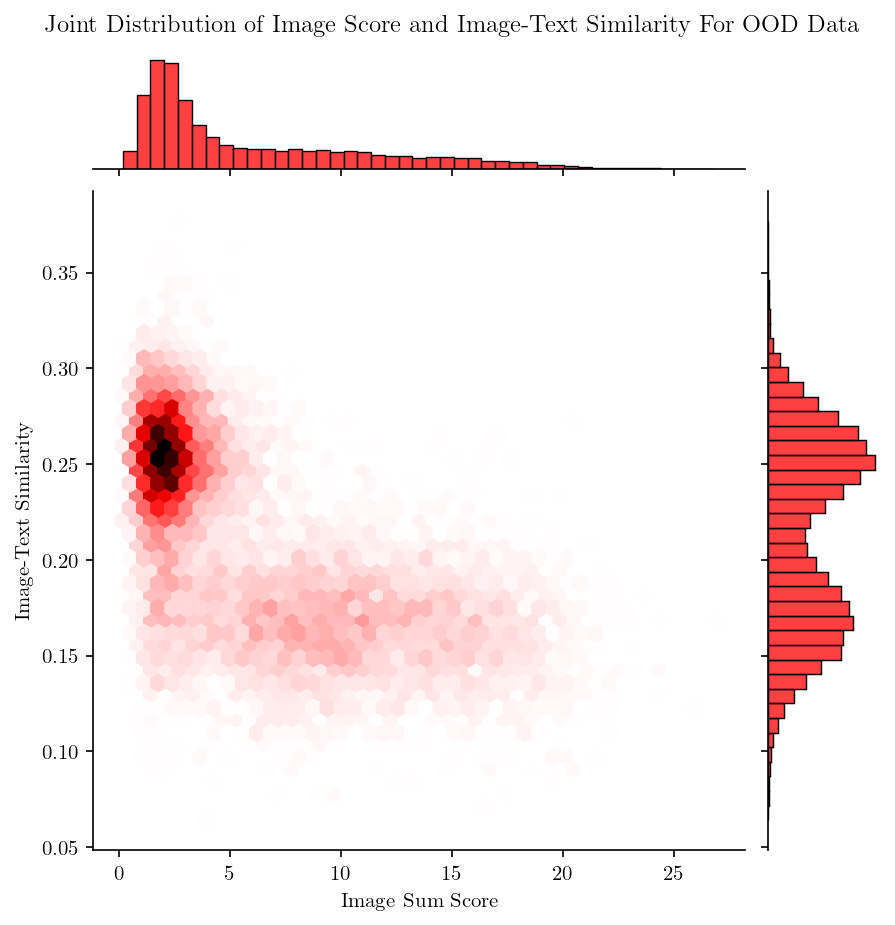

In [34]:
import seaborn as sns

sns.jointplot(x=f'{score_type}_{type}_image', y=f'image_text_similarity', data=df_test[df_test['OOD'] == 1], kind='hex')
plt.suptitle(f'Joint Distribution of Image Score and Image-Text Similarity For ID Data', y=1.02)
plt.xlabel(f'Image {type.title()} Score')
plt.ylabel('Image-Text Similarity')
plt.savefig(f'{data_loader.data_dir}/CLIP/qa_imgs/ID_distribution.pdf', bbox_inches='tight')
plt.show()

sns.jointplot(x=f'{score_type}_{type}_image', y=f'image_text_similarity', data=df_test[df_test['OOD'] == 0], kind='hex', color='red')
plt.suptitle(f'Joint Distribution of Image Score and Image-Text Similarity For OOD Data', y=1.02)
plt.xlabel(f'Image {type.title()} Score')
plt.ylabel('Image-Text Similarity')
plt.savefig(f'{data_loader.data_dir}/CLIP/qa_imgs/OOD_distribution.pdf', bbox_inches='tight')

plt.show()

In [31]:
# Initialize lists to store data
metrics = []
values = []
scores = [] 

def eval_dict(score):
    return {
        "FPR": lambda x: ev.fpr_evaluation(x['OOD'].values, x[score].values, 0.95),
        "AUROC": lambda x: ev.auroc_evaluation(x['OOD'].values, x[score].values),
        "AUPR": lambda x: ev.aupr_evaluation(x['OOD'].values, x[score].values)
    }

# Define the metrics and corresponding functions
metric_functions = {
    "Max Cosine": {
        "Image": eval_dict('image_score_max'),
        "Dialogue": eval_dict('dialogue_score_max'),
        "Overall": eval_dict('overall_simialrity')
    },
    "Sum Cosine": {
        "Image": eval_dict('image_score'),
        "Dialogue": eval_dict('dialogue_score'),
        "Overall": eval_dict('overall_simialrity_sum')
    },
    "Energy Sum": {
        "Image": eval_dict('energy_sum_image'),
        "Dialogue": eval_dict('energy_sum_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity_sum')
    },
    "Energy Max": {
        "Image": eval_dict('energy_max_image'),
        "Dialogue": eval_dict('energy_max_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity_max')
    },
    "MSP": {
        "Image": eval_dict('msp_max_image'),
        "Dialogue": eval_dict('msp_max_dialogue'),
        "Overall": eval_dict('msp_overall_simialrity_max')
    },
    "Max Prob": {
        "Image": eval_dict('mp_max_image'),
        "Dialogue": eval_dict('mp_max_dialogue'),
        "Overall": eval_dict('mp_overall_simialrity_max')
    },
    "Max Logits": {
        "Image": eval_dict('logits_max_image'),
        "Dialogue": eval_dict('logits_max_dialogue'),
        "Overall": eval_dict('logits_overall_simialrity_max')
    },
    "Sum Logits": {
        "Image": eval_dict('logits_sum_image'),
        "Dialogue": eval_dict('logits_sum_dialogue'),
        "Overall": eval_dict('logits_overall_simialrity_sum')
    }
}

# Loop through each metric and calculate values
for score, items in metric_functions.items():
    scores.extend([score] * len(items) * 3)
    for metric, funcs in items.items():
        metrics.extend([metric] * len(funcs))
        values.extend([func(df_test) for func in funcs.values()])

# Create DataFrame
df = pd.DataFrame({"Metric": metrics, "Value": values, "Score": scores})
df['Value'] = df['Value'].apply(lambda x: round(x, 3))
#df_grouped = df.groupby('Metric')['Value'].apply(list).reset_index()
result = df.groupby(['Metric', 'Score'])['Value'].agg(list).unstack().transpose()
result[['Image', 'Dialogue', 'Overall']]

Metric,Image,Dialogue,Overall
Score,,,
Energy Max,"[0.625, 0.747, 0.815]","[0.859, 0.721, 0.81]","[0.598, 0.862, 0.932]"
Energy Sum,"[0.546, 0.762, 0.821]","[0.698, 0.748, 0.819]","[0.511, 0.872, 0.934]"
MSP,"[0.92, 0.57, 0.737]","[0.932, 0.604, 0.762]","[0.752, 0.723, 0.831]"
Max Cosine,"[0.908, 0.618, 0.758]","[0.961, 0.523, 0.708]","[0.959, 0.544, 0.724]"
Max Logits,"[0.625, 0.747, 0.815]","[0.859, 0.721, 0.81]","[0.607, 0.86, 0.931]"
Max Prob,"[0.625, 0.747, 0.815]","[0.859, 0.721, 0.81]","[0.569, 0.859, 0.924]"
Sum Cosine,"[0.945, 0.543, 0.712]","[0.965, 0.497, 0.693]","[0.963, 0.506, 0.695]"
Sum Logits,"[0.923, 0.65, 0.783]","[0.963, 0.648, 0.782]","[0.975, 0.546, 0.709]"


In [32]:
markdown_table = result[['Image', 'Dialogue', 'Overall']].to_markdown()

markdown_table

'| Score      | Image                 | Dialogue              | Overall               |\n|:-----------|:----------------------|:----------------------|:----------------------|\n| Energy Max | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.598, 0.862, 0.932] |\n| Energy Sum | [0.546, 0.762, 0.821] | [0.698, 0.748, 0.819] | [0.511, 0.872, 0.934] |\n| MSP        | [0.92, 0.57, 0.737]   | [0.932, 0.604, 0.762] | [0.752, 0.723, 0.831] |\n| Max Cosine | [0.908, 0.618, 0.758] | [0.961, 0.523, 0.708] | [0.959, 0.544, 0.724] |\n| Max Logits | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.607, 0.86, 0.931]  |\n| Max Prob   | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.569, 0.859, 0.924] |\n| Sum Cosine | [0.945, 0.543, 0.712] | [0.965, 0.497, 0.693] | [0.963, 0.506, 0.695] |\n| Sum Logits | [0.923, 0.65, 0.783]  | [0.963, 0.648, 0.782] | [0.975, 0.546, 0.709] |'

## Results on OOD

# Without Mismatching Pair, Test ID instance 23233, Test OOD instance 6051


## Without image text similarity score
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.32, 0.952, 0.988]  |
| Energy Sum | [0.236, 0.964, 0.991] | [0.508, 0.935, 0.984] | [0.151, 0.974, 0.994] |
| MSP        | [0.894, 0.625, 0.873] | [0.919, 0.68, 0.905]  | [0.885, 0.657, 0.889] |
| Max Cosine | [0.877, 0.711, 0.905] | [0.971, 0.54, 0.835]  | [0.964, 0.579, 0.857] |
| Max Logits | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.331, 0.951, 0.988] |
| Max Prob   | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.507, 0.927, 0.982] |
| Sum Cosine | [0.94, 0.576, 0.84]   | [0.978, 0.494, 0.814] | [0.972, 0.51, 0.817]  |
| Sum Logits | [0.904, 0.762, 0.934] | [0.974, 0.758, 0.931] | [0.932, 0.788, 0.943] |

## With image text similarity score overall
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.346, 0.945, 0.986] |
| Energy Sum | [0.236, 0.964, 0.991] | [0.508, 0.935, 0.984] | [0.194, 0.97, 0.993]  |
| MSP        | [0.894, 0.625, 0.873] | [0.919, 0.68, 0.905]  | [0.908, 0.574, 0.846] |
| Max Cosine | [0.877, 0.711, 0.905] | [0.971, 0.54, 0.835]  | [0.964, 0.579, 0.857] |
| Max Logits | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.35, 0.945, 0.986]  |
| Max Prob   | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.731, 0.793, 0.934] |
| Sum Cosine | [0.94, 0.576, 0.84]   | [0.978, 0.494, 0.814] | [0.972, 0.51, 0.817]  |
| Sum Logits | [0.904, 0.762, 0.934] | [0.974, 0.758, 0.931] | [0.955, 0.764, 0.934] |

# With 5000 mismatching pairs, testing ID instance 23233, test OOD isntance 11051


## Without image text similarity
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.614, 0.758, 0.838] |
| Energy Sum | [0.546, 0.762, 0.821] | [0.698, 0.748, 0.819] | [0.522, 0.767, 0.843] |
| MSP        | [0.92, 0.57, 0.737]   | [0.932, 0.604, 0.762] | [0.921, 0.598, 0.773] |
| Max Cosine | [0.908, 0.618, 0.758] | [0.961, 0.523, 0.708] | [0.959, 0.544, 0.724] |
| Max Logits | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.619, 0.758, 0.839] |
| Max Prob   | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.707, 0.765, 0.848] |
| Sum Cosine | [0.945, 0.543, 0.712] | [0.965, 0.497, 0.693] | [0.963, 0.506, 0.695] |
| Sum Logits | [0.923, 0.65, 0.783]  | [0.963, 0.648, 0.782] | [0.953, 0.672, 0.814] |

## With imge text similarity score on overall 
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.598, 0.862, 0.932] |
| Energy Sum | [0.546, 0.762, 0.821] | [0.698, 0.748, 0.819] | [0.511, 0.872, 0.934] |
| MSP        | [0.92, 0.57, 0.737]   | [0.932, 0.604, 0.762] | [0.752, 0.723, 0.831] |
| Max Cosine | [0.908, 0.618, 0.758] | [0.961, 0.523, 0.708] | [0.959, 0.544, 0.724] |
| Max Logits | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.607, 0.86, 0.931]  |
| Max Prob   | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.569, 0.859, 0.924] |
| Sum Cosine | [0.945, 0.543, 0.712] | [0.965, 0.497, 0.693] | [0.963, 0.506, 0.695] |
| Sum Logits | [0.923, 0.65, 0.783]  | [0.963, 0.648, 0.782] | [0.975, 0.546, 0.709] |






